# Importing the necessary tools

In [1]:
#magic functions
%load_ext sql
%matplotlib inline
%sql sqlite:////forecasting/stocks.sqlite

#complementary funtions
from pprint import pprint

# Etract
import yfinance as yf
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
from plotly.subplots import make_subplots
from plotly.offline import iplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# transform and load
import sqlite3
from datetime import date

#model
from arch import arch_model

# Data class Database

In [5]:
class stock_data():
    """
    manipulate stock data
    """
    def __init__(self):
        self.connection = sqlite3.connect("stocks.sqlite",check_same_thread=False)
    
    def delete_table(self,ticker):
        """
        delete the ticker from the database
        """
        cursor = self.connection.cursor()
        cursor.execute(f"DROP TABLE {ticker}")
        print(f"table {ticker} deleted")
        
    def update_and_read(self,ticker):
        """
        function to read the table from the database
        if exists it updates it to the database and reads the data
        if not it will be downloaded and added to the database

        parameters
        ----------
        ticker : ticker sympol

        Returns
        -------
        pd.DataFrame
           Index is DatetimeIndex "date". Columns are 'open', 'high',
           'Open' , 'High' , 'Low' , 'Close' , 'Adj close', and 'volume'. All columns are numeric.
        """
    
        today_date = str(date.today())
    
        try:
            sql = f"""
            SELECT *
            FROM '{ticker}'
            """
            df = pd.read_sql(sql,con=self.connection,index_col="Date")
            print("ticker exists in the database")
            print(f"latest date for {ticker} is : {str(df.index[-1]).split()[0]}")

            if str(df.index[-1]).split()[0] != today_date:
                print("the gap between the last date and today's date is : "," ".join(str(pd.to_datetime(today_date)-pd.to_datetime(df.index[-1])).split()[:-1]))
                print("updating ticker")
                print("Loading:")
                new_data = yf.download(tickers=ticker,start=str(df.index[-1]).split()[0],interval="1d")
                n_inserted_update = df.to_sql(name=ticker,con=self.connection,if_exists="append")
                print(f"number of inserted data is {new_data.shape[0]}")

            df = pd.read_sql(sql,con=self.connection,index_col="Date").drop_duplicates()
            print("shape ",df.shape)
            print("\n----------------------")

        except:
            print(f"this table does not exist\ndownloading {ticker} ...")
            df = yf.download(tickers=ticker)
            n_inserted = df.to_sql(name=ticker,con=self.connection,if_exists="fail")
            print(f"number of inserted data is : {n_inserted}")
            print("shape ",df.shape)
            print("\n----------------------")
        
        return df

## update and read the Data

In [7]:
#tickers
for i in ["AAPL","TSLA","META","VOD"]:
    data = stock_data()
    data.update_and_read(i);

ticker exists in the database
latest date for AAPL is : 2023-05-23
the gap between the last date and today's date is :  1 days
updating ticker
Loading:
[*********************100%***********************]  1 of 1 completed
number of inserted data is 1
shape  (10701, 6)

----------------------
ticker exists in the database
latest date for TSLA is : 2023-05-23
the gap between the last date and today's date is :  1 days
updating ticker
Loading:
[*********************100%***********************]  1 of 1 completed
number of inserted data is 1
shape  (3248, 6)

----------------------
ticker exists in the database
latest date for META is : 2023-05-23
the gap between the last date and today's date is :  1 days
updating ticker
Loading:
[*********************100%***********************]  1 of 1 completed
number of inserted data is 1
shape  (2771, 6)

----------------------
ticker exists in the database
latest date for VOD is : 2023-05-23
the gap between the last date and today's date is :  1 days


In [8]:
data.delete_table("AAPL")

table AAPL deleted


In [9]:
data.update_and_read("AAPL")

this table does not exist
downloading AAPL ...
[*********************100%***********************]  1 of 1 completed
number of inserted data is : 10701
shape  (10701, 6)

----------------------


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099584,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094388,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087461,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089625,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092224,73449600
...,...,...,...,...,...,...
2023-05-17,171.710007,172.929993,170.419998,172.690002,172.690002,57951600
2023-05-18,173.000000,175.240005,172.580002,175.050003,175.050003,65496700
2023-05-19,176.389999,176.389999,174.940002,175.160004,175.160004,55772400


In [35]:
%%sql
SELECT * 
FROM AAPL
LIMIT 1

 * sqlite:////forecasting/stocks.sqlite
Done.


Date,Open,High,Low,Close,Adj Close,Volume
1980-12-12 00:00:00,0.1283479928970337,0.1289059966802597,0.1283479928970337,0.1283479928970337,0.09958380460739136,469033600


In [36]:
#ticker to investigate and forecast
ticker = "AAPL"

#number of observation we want
number_of_observation = 2300

if number_of_observation:
    sql=f"""
        SELECT * 
        FROM {ticker}
        ORDER BY Date DESC 
        LIMIT {number_of_observation}
        """
else:
    sql=f"""
        SELECT * 
        FROM {ticker}
        """
    
df = pd.read_sql(sql=sql,con=data.connection,index_col="Date")
df.index = pd.to_datetime(df.index).normalize()

# visualizations

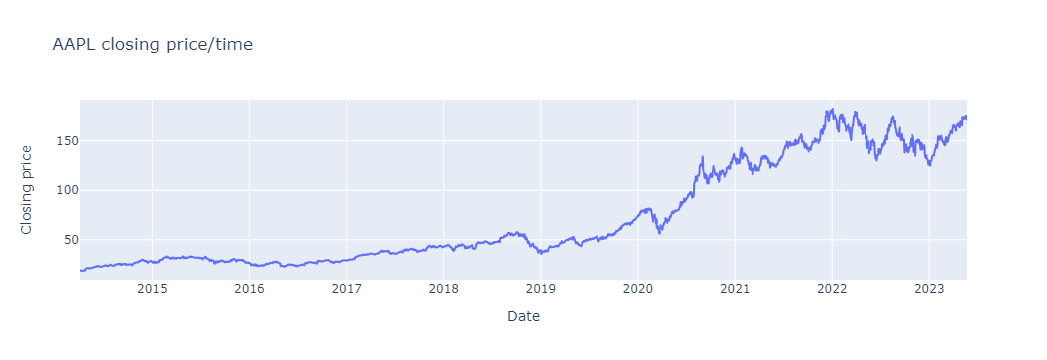

In [37]:
fig = ex.line(data_frame=df,x=df.index,y=df["Close"],title=f"{ticker} closing price/time")
fig.update_layout(xaxis_title="Date",yaxis_title="Closing price")

In [38]:
#sort dataframe
df.sort_index(ascending=True,inplace=True)

# Create "return" column
df["return"] = df["Close"].pct_change()*100

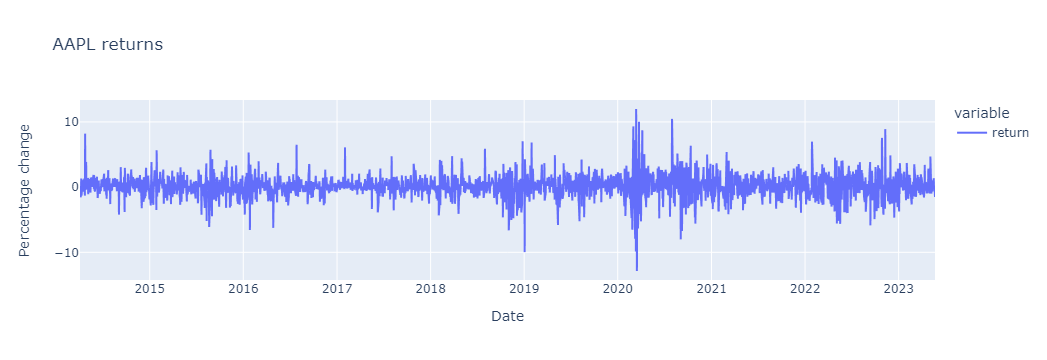

In [39]:
fig = ex.line(df["return"],title=f"{ticker} returns")
fig.update_layout(xaxis_title="Date",yaxis_title="Percentage change")

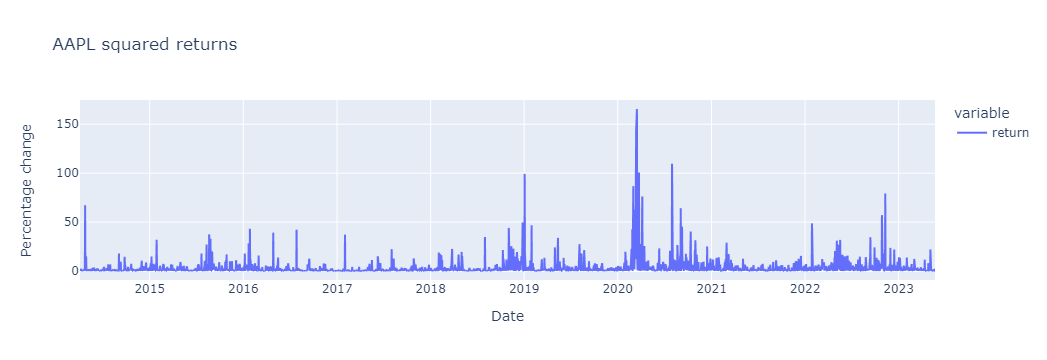

In [40]:
fig = ex.line(df["return"]**2,title=f"{ticker} squared returns")
fig.update_layout(xaxis_title="Date",yaxis_title="Percentage change")

In [41]:
y = df["return"].dropna()
y

Date
2014-04-07   -1.570078
2014-04-08   -0.005723
2014-04-09    1.314381
2014-04-10   -1.289787
2014-04-11   -0.739282
                ...   
2023-05-17    0.360316
2023-05-18    1.366611
2023-05-19    0.062840
2023-05-22   -0.548074
2023-05-23   -1.515499
Name: return, Length: 2299, dtype: float64

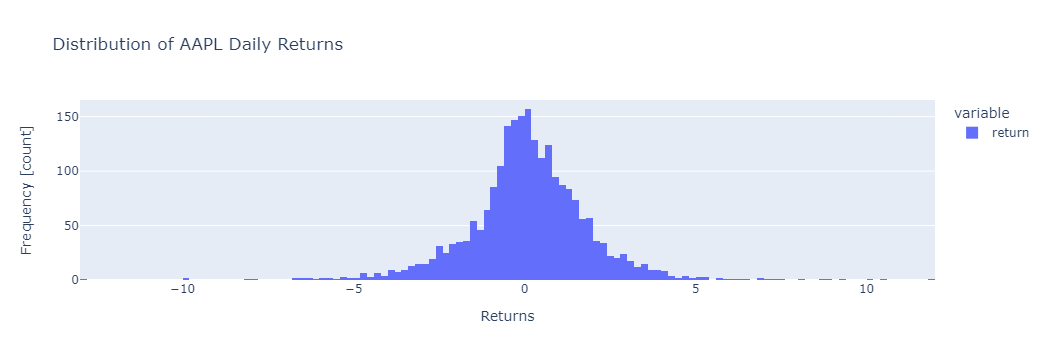

In [42]:
fig = ex.histogram(y,title=f"Distribution of {ticker} Daily Returns")
fig.update_layout(xaxis_title="Returns",yaxis_title="Frequency [count]")

## volatility (daily , annual)

In [43]:
daily_volatility = y.std()
annual_volatility = daily_volatility * np.sqrt(252)

print(f"{ticker} Daily Volatility:", daily_volatility)
print(f"{ticker} Annual Volatility:", annual_volatility)

AAPL Daily Volatility: 1.831782209441208
AAPL Annual Volatility: 29.078641093283213


In [44]:
rolling_50d_volatility = y.rolling(window=50).std().dropna()
print("50d_volatility shape:", rolling_50d_volatility.shape)
rolling_50d_volatility.head()

50d_volatility shape: (2250,)


Date
2014-06-17    1.546314
2014-06-18    1.520754
2014-06-19    1.523515
2014-06-20    1.531666
2014-06-23    1.514317
Name: return, dtype: float64

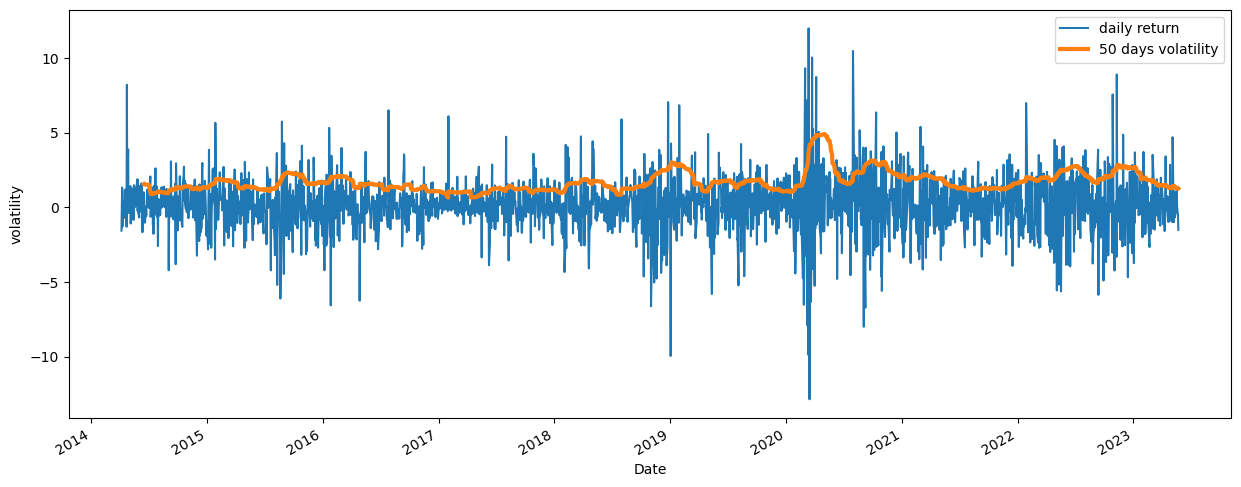

In [45]:
fig, ax = plt.subplots(figsize=(15, 6))

y.plot(ax=ax,label="daily return")
rolling_50d_volatility.plot(ax=ax,label="50 days volatility",linewidth=3)

# Add x-axis label
plt.xlabel("Date")
plt.ylabel("volatility")
# Add legend
plt.legend();

## ACF and PACF plots

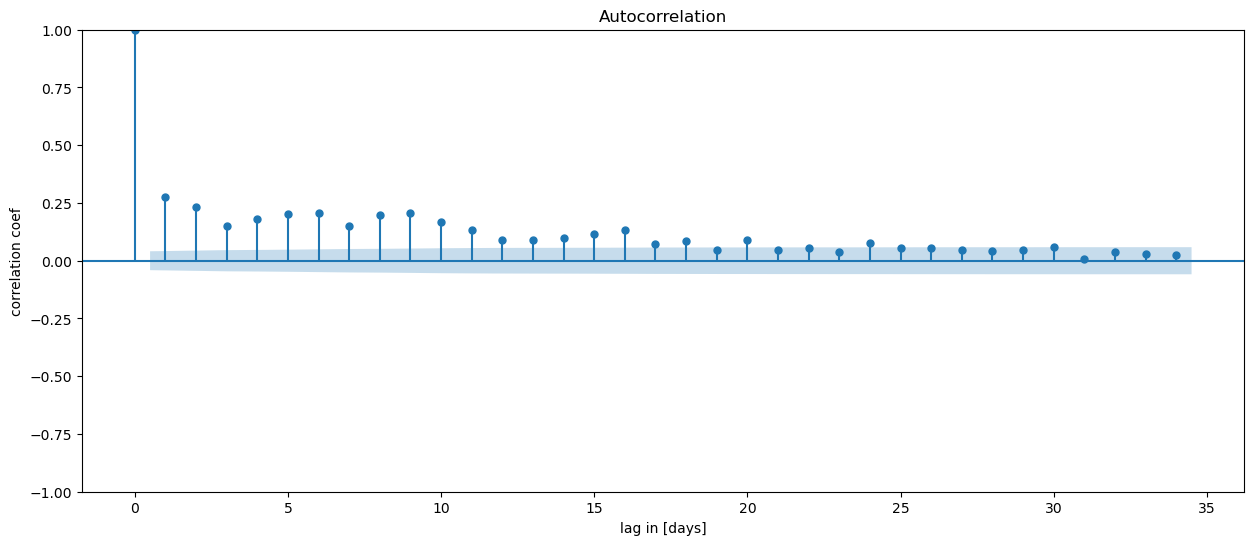

In [46]:
# ACF plot of squared returns
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y**2,ax=ax)

# Add axis labels
plt.xlabel("lag in [days]")
plt.ylabel("correlation coef");

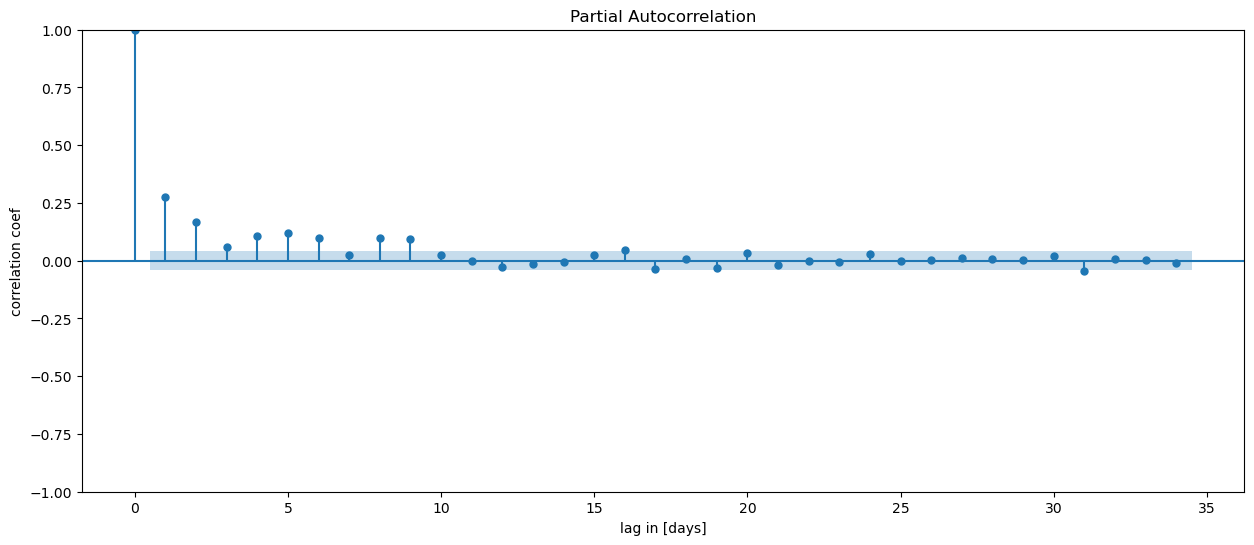

In [47]:
#PACF plot of squared returns
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y**2,ax=ax,method='ywm')

# Add axis labels
plt.xlabel("lag in [days]")
plt.ylabel("correlation coef");

# Garch Model for predicting volatility

In [48]:
#Split data 80/20 %
cutoff = int(len(y)/0.8)
y_train = y.iloc[:cutoff]
print("y_train shape:", y_train.shape)

y_train shape: (2299,)


In [49]:
model = arch_model(y_train,
                   p=1,
                   q=1,
                   rescale=False).fit(disp=0)
#stats summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4426.18
Distribution:                  Normal   AIC:                           8860.37
Method:            Maximum Likelihood   BIC:                           8883.33
                                        No. Observations:                 2299
Date:                Wed, May 24 2023   Df Residuals:                     2298
Time:                        01:26:23   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1871  3.498e-02      5.348  8.877e-08 [  0.119,  0.256]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1579  4.929e-02      3.204  1.357e-03 [6.130e-02,  0.255]
alpha[1]       0.1105  2.395e-02      4.613  3.964e-06 [6.354e-02,  0.157]
beta[1]        0.8413  3.142e-02     26.776 6.219e-158   [  0.780,  0.903]
==========================================================================

Covariance estimator: robust
"""

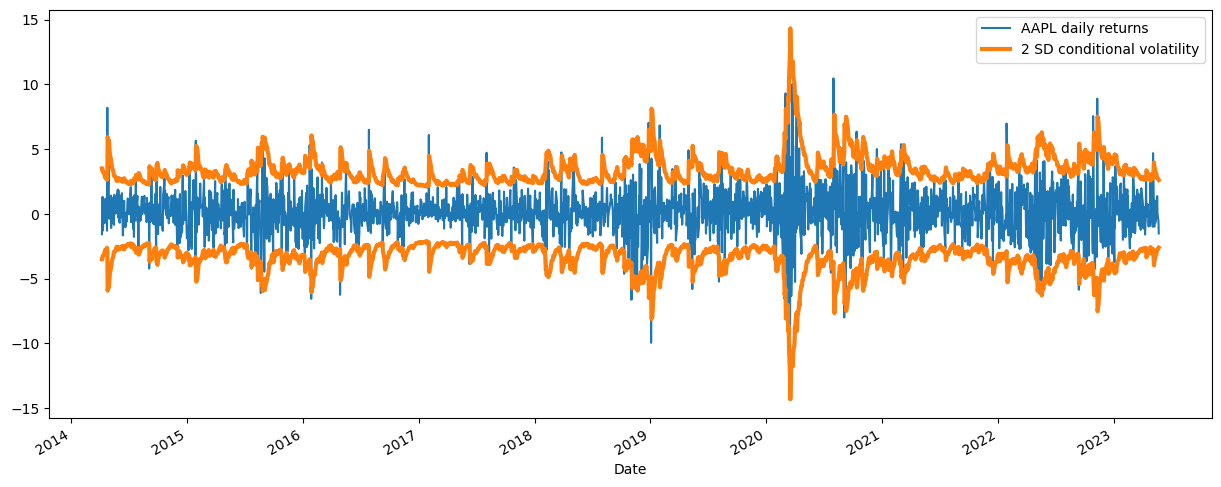

In [50]:
#Conditional volitility plot
fig, ax = plt.subplots(figsize=(15, 6))

# Plot y_train
y_train.plot(ax=ax,label=f"{ticker} daily returns")

# Plot conditional volatility * 2
(model.conditional_volatility * 2).plot(ax=ax,color="C1",linewidth=3,label="2 SD conditional volatility")

# Plot conditional volatility * -2
(model.conditional_volatility.rename("") * -2).plot(ax=ax,color="C1",linewidth=3)

# Add axis labels
plt.xlabel("Date")

# Add legend
plt.legend();

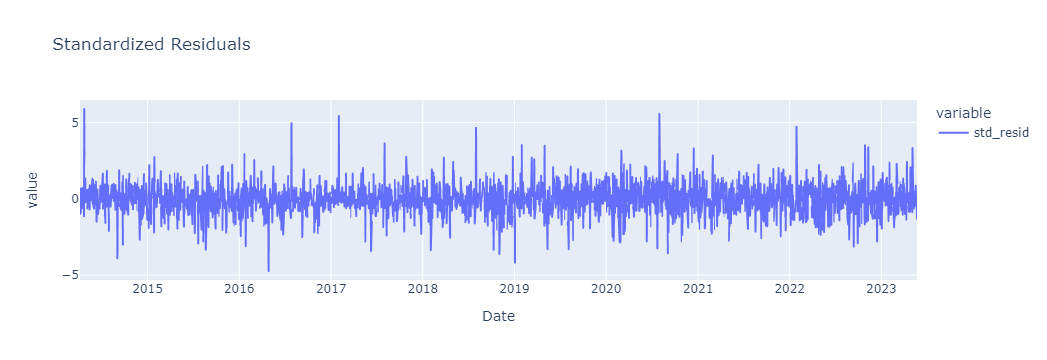

In [51]:
# Plot standardized residuals
fig = ex.line(model.std_resid,
              title="Standardized Residuals")

# Add axis labels
fig.update_layout(xaxis_title ="Date")

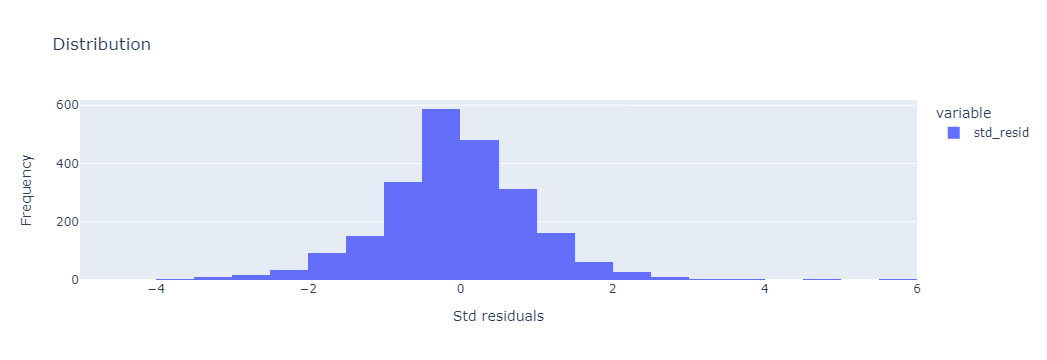

In [52]:
fig = ex.histogram(model.std_resid,title=f"Distribution",nbins=25)
fig.update_layout(xaxis_title="Std residuals",yaxis_title="Frequency")

Text(0.5, 0, 'Correlation coef')

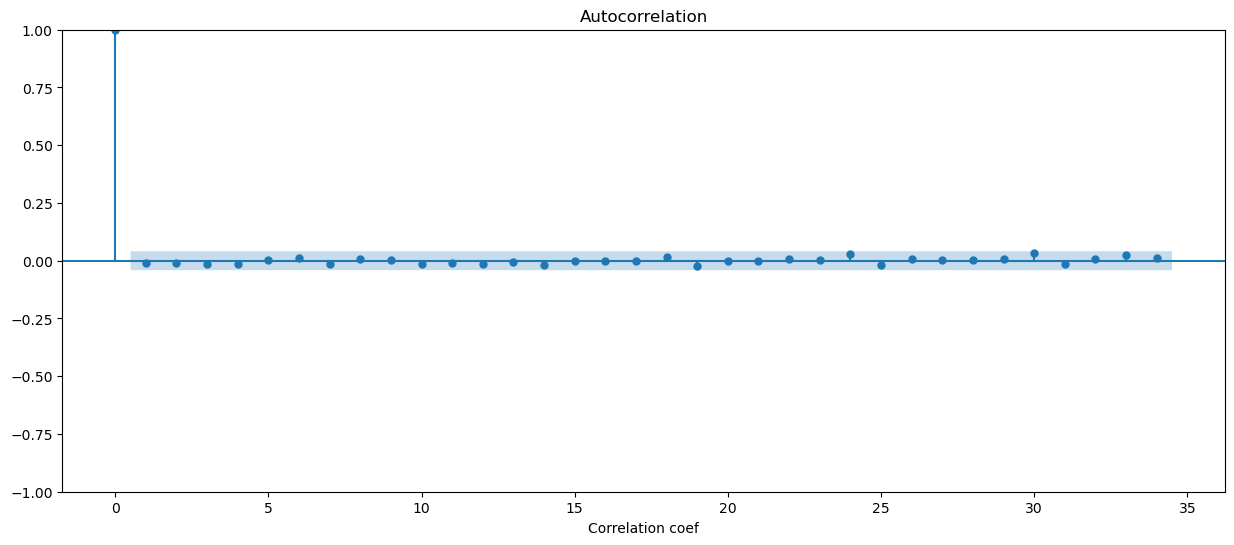

In [53]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2,ax=ax)

# Add axis labels
plt.xlabel("lag")
plt.xlabel("Correlation coef")

## test

In [54]:
one_day_forecast = model.forecast(horizon=1,reindex=False).variance
print("Date : ",str(one_day_forecast.index.values[0])[:10])
print("the true value : ",y.iloc[-1])
print("the forecasted value : ",one_day_forecast.apply(np.sqrt).iloc[0,0])

Date :  2023-05-23
the true value :  -1.5154991021227304
the forecasted value :  1.382983430200708


### walk-forward validation

In [55]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(y) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = y.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train,p=1,q=1,rescale=False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon=1,reindex=False).variance.iloc[0,0] ** 0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=y.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (459,)


Date
2021-07-28    1.536041
2021-07-29    1.536619
2021-07-30    1.450267
2021-08-02    1.373301
2021-08-03    1.316882
dtype: float64

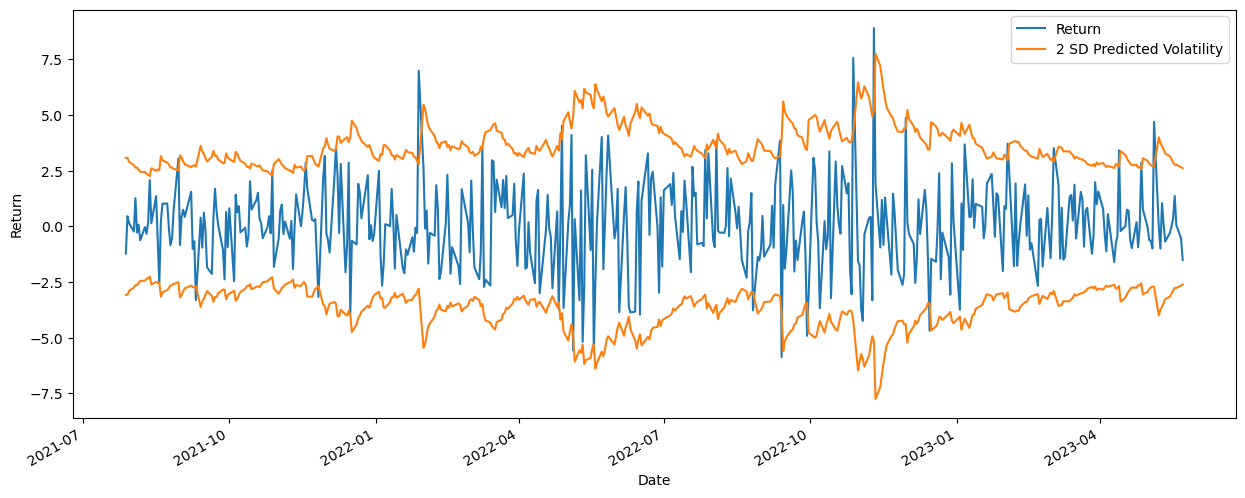

In [56]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
y.tail(test_size).plot(ax=ax, label="Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1",label="")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

## 10-day forecast

In [57]:
# Generate 10-day volatility forecast
prediction = model.forecast(horizon=10, reindex=False).variance ** 0.5

# Calculate forecast start date
start = prediction.index[0]+pd.DateOffset(days=1)

# Create date range
prediction_dates = pd.bdate_range(start=start,periods=prediction.shape[1])

# Create prediction index labels
prediction_index = [d.isoformat() for d in prediction_dates]

print("predictions : \n")
pprint(prediction)

print("-"*80,"\nprediction indices : \n")
pprint(prediction_index)

predictions : 

                h.01      h.02      h.03    h.04      h.05      h.06  \
Date                                                                   
2023-05-22  1.305098  1.333823  1.360598  1.3856  1.408983  1.430883   

                h.07      h.08      h.09      h.10  
Date                                                
2023-05-22  1.451418  1.470696  1.488811  1.505849  
-------------------------------------------------------------------------------- 
prediction indices : 

['2023-05-23T00:00:00',
 '2023-05-24T00:00:00',
 '2023-05-25T00:00:00',
 '2023-05-26T00:00:00',
 '2023-05-29T00:00:00',
 '2023-05-30T00:00:00',
 '2023-05-31T00:00:00',
 '2023-06-01T00:00:00',
 '2023-06-02T00:00:00',
 '2023-06-05T00:00:00']


In [58]:
forecast_of_10_days = pd.Series(prediction.values.flatten(),
                                index=pd.to_datetime(prediction_index).normalize())
forecast_of_10_days

2023-05-23    1.305098
2023-05-24    1.333823
2023-05-25    1.360598
2023-05-26    1.385600
2023-05-29    1.408983
2023-05-30    1.430883
2023-05-31    1.451418
2023-06-01    1.470696
2023-06-02    1.488811
2023-06-05    1.505849
Freq: B, dtype: float64

## Forecast plot

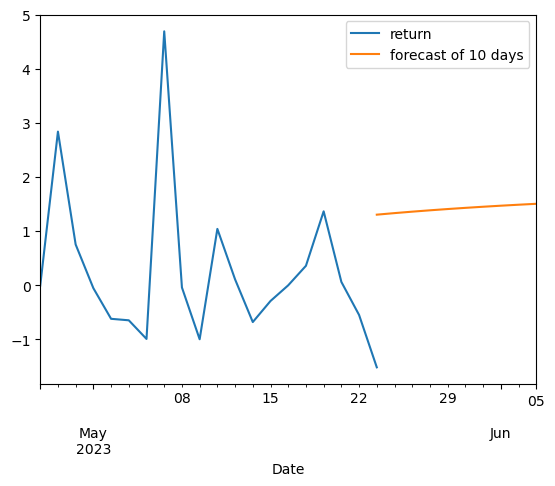

In [67]:
y.iloc[-20:].plot()
forecast_of_10_days.plot(label="forecast of 10 days")
plt.legend();